# Import

In [1]:
import os
import time
import json
import random
import datetime
import numpy as np
import pandas as pd

from IPython.display import display

from pathlib import Path
from tyssue import config
from tyssue import Sheet
from tyssue.io import hdf5
from tyssue.io.hdf5 import load_datasets
from tyssue.topology import all_rearangements
from tyssue.core.history import HistoryHdf5
from tyssue.dynamics import SheetModel as basemodel
from tyssue.solvers.quasistatic import QSSolver
from tyssue.draw import sheet_view
from tyssue.draw.plt_draw import quick_edge_draw
from tyssue.draw.ipv_draw import sheet_view as ipv_draw 

from tyssue.behaviors.event_manager import EventManager
from tyssue.behaviors.sheet.apoptosis_events import apoptosis
from tyssue.behaviors.sheet.basic_events import reconnect

from tyssue.utils import to_nd

import matplotlib.pyplot as plt
%matplotlib inline

try:
    import seaborn as sns
except ImportError:
    print('Seaborn not found')

import ipyvolume as ipv

Seaborn not found


In [2]:
from polarity.apoptosis import apoptosis, apoptosis_patterning
from polarity.dynamics import EllipsoidLameGeometry as geom
from polarity.polarity import model
from polarity.toolbox import (init,
                              define_fold_position,
                              apoptosis_ventral,
                              apoptosis_lateral,
                              apoptosis_dorsal,
                              define_polarity_old,
                             )


from polarity.delamination import delamination

from polarity.settings import (apopto_pattern_kwargs,
                               apoptosis_settings,
                               contraction_lt_kwargs,
                               rosette_kwargs,
                               delaminate_settings)

# Working directory

In [3]:
SIM_DIR = Path('/home/admin-suz/Documents/Simulations/')

today = datetime.date.today().strftime('%Y%m%d')
sim_save_dir = SIM_DIR/f'{today}-QSSolver-homogenous_Ablation'

try:
    os.mkdir(sim_save_dir)
except FileExistsError:
    pass

# Define solver, model and process settings

In [4]:
solver = QSSolver(with_t1=False, with_t3=False, with_collisions=False)


# Initiate Tissue

In [5]:
sheet = init(hf5_filename='super_egg.hf5',
             json_filename = 'superegg_final.json')

sheet.settings['geometry'] = "spherical"
sheet.settings['lumen_vol_elasticity'] = 1.e-5
sheet.settings['barrier_radius'] = 100

sheet.vert_df['barrier_elasticity'] = 280.0

# A définir en fonction de l'angle de la jonction
sheet.edge_df['weight'] = 1.
sheet.edge_df['weighted_length'] = sheet.edge_df.weight * sheet.edge_df.length

sheet.face_df['apoptosis'] = 0
sheet.face_df['current_traction'] = 0.0
sheet.face_df['radial_tension'] = 0.0
sheet.face_df['prefered_perimeter'] = 2.*np.sqrt(sheet.face_df['prefered_area'])
sheet.face_df['perimeter_elasticity'] = 10.
sheet.face_df['area_elasticity'] = 1.


sheet.settings['apopto_pattern_kwargs'] = apopto_pattern_kwargs
sheet.settings['apoptosis'] = apoptosis_settings
sheet.settings['rosette_kwargs'] = rosette_kwargs
sheet.settings['contraction_lt_kwargs'] = contraction_lt_kwargs
sheet.settings['delaminate_setting'] = delaminate_settings

geom.update_all(sheet)

In [6]:
define_fold_position(sheet, fold_number = 1, position=[-8, 8])
sheet.face_df.apoptosis = 0

apoptosis_ventral(sheet, 1)
apoptosis_lateral(sheet, 1)
apoptosis_dorsal(sheet, 1)

"""
ipv.clear()
# code couleur profondeur du tissu
fig, mesh = sheet_view(sheet, mode="3D", coords=['z', 'x', 'y'],
                   edge={'color':'lightslategrey',
                         'visible':True},
                   face={'color': sheet.face_df.apoptosis,
                        'colormap':'Reds',
                        'visible':True})
fig

print(len(sheet.face_df[sheet.face_df.fold>0]))
print(len(sheet.face_df[sheet.face_df.apoptosis>0]))"""


"""l = [   5, 37,   71,   72, 95,  241,  384,  502,
     559,  653,  696,  706,  776, 848,  958,  985, 1008, 1075,
    1135, 1215, 1264, 1312, 1330, 1393, 1416, 1424, 1429, 1435, 1452,
    1466, 1491, 1543, 1544, 1583]
for i in l :
    sheet.face_df.loc[i, 'apoptosis']=1
"""

"l = [   5, 37,   71,   72, 95,  241,  384,  502,\n     559,  653,  696,  706,  776, 848,  958,  985, 1008, 1075,\n    1135, 1215, 1264, 1312, 1330, 1393, 1416, 1424, 1429, 1435, 1452,\n    1466, 1491, 1543, 1544, 1583]\nfor i in l :\n    sheet.face_df.loc[i, 'apoptosis']=1\n"

In [7]:
print(len(sheet.face_df[sheet.face_df.apoptosis==1]))
print (sheet.face_df[sheet.face_df.apoptosis==1].index)

35
Int64Index([   3,    4,    7,   71,   93,  146,  178,  194,  197,  405,  440,
             502,  540,  612,  628,  653,  780,  892,  985, 1008, 1020, 1062,
            1075, 1096, 1135, 1158, 1237, 1273, 1330, 1393, 1429, 1452, 1491,
            1544, 1603],
           dtype='int64', name='face')


In [8]:
sheet.face_df['is_mesoderm']=0

#sheet.face_df.loc[330, 'is_mesoderm']=1

In [26]:
#z_boundary=[-90,90], x_boundary=[-30,150]
sheet.face_df[(sheet.face_df.x>-30) & (sheet.face_df.x<150) & 
              (sheet.face_df.z>-90) & (sheet.face_df.z<90)].index.to_numpy()

array([   0,    1,    2,    3,    4,    5,    6,   18,   19,   20,   21,
         22,   23,   24,   25,   31,   32,   52,   55,   56,   57,   58,
         59,   60,   61,   62,   63,   64,   65,   69,   73,   79,   80,
         81,   82,   83,   84,   85,   86,   87,   88,   89,   90,   91,
         92,   93,   94,   95,   96,   97,   98,   99,  100,  102,  108,
        109,  110,  111,  125,  126,  142,  145,  146,  148,  149,  150,
        151,  152,  153,  154,  157,  158,  159,  160,  161,  169,  170,
        171,  172,  173,  174,  175,  176,  177,  178,  179,  180,  181,
        182,  183,  184,  189,  190,  191,  192,  193,  194,  195,  196,
        197,  198,  202,  212,  213,  215,  216,  217,  218,  219,  220,
        221,  222,  223,  224,  226,  227,  231,  236,  237,  244,  246,
        247,  248,  249,  250,  251,  252,  253,  254,  255,  256,  257,
        259,  260,  261,  264,  265,  266,  267,  268,  270,  272,  273,
        274,  275,  276,  277,  278,  283,  284,  2

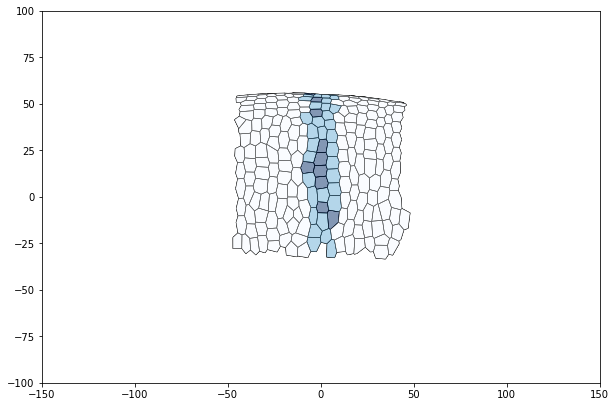

In [29]:
#sheet.face_df.loc[220, 'apoptosis']=15
def draw_specs(sheet):
    specs = {
        'edge': {
            'visible': True,
            'color':'k'
            #'color': sheet.edge_df['stress'],
            #"colormap":'bwr',
            #'color_range':(-20,20)
        },
        'face': {
            'visible': True,
            'color':sheet.face_df.apoptosis+sheet.face_df.fold,
            'colormap': 'Blues',
            'alpha':0.5

        },
        'vert':{
            'visible':False,
            's':100,
            'alpha': 0.3,
            'zorder': 2,


        }

    }
    return specs

sheet_=sheet.extract_bounding_box(y_boundary=(0,150), z_boundary=[-45,45], x_boundary=[-30,150])

fig, ax = sheet_view(sheet_, ['z', 'x'], mode="2D", **draw_specs(sheet_))
ax.set_ylim(-100,100)
ax.set_xlim(-150,150)

fig.set_size_inches(10,10)

In [10]:
define_polarity_old(sheet, 1, 1)
print(sheet.edge_df.weight.unique())
geom.normalize_weights(sheet)

[1.]


In [11]:
res = solver.find_energy_min(sheet, geom, model, options={"gtol": 1e-8})
print(res)

      fun: 1438.571504927989
 hess_inv: <9900x9900 LbfgsInvHessProduct with dtype=float64>
      jac: array([-1.29010139e-03,  2.73492232e-05, -4.96328183e-04, ...,
       -4.08753456e-07,  2.20866024e-04, -9.68303781e-05])
  message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 585
      nit: 470
   status: 0
  success: True
        x: array([ -7.78640811,  58.77654219, -13.68830008, ...,  45.60987362,
        23.53723038, -61.3788114 ])


/home/admin-suz/miniconda3/lib/python3.7/site-packages/tyssue-0.6.4-py3.7-linux-x86_64.egg/tyssue/draw/plt_draw.py:313: UserWarning: Attempting to draw a colormap with a uniform value
  warnings.warn("Attempting to draw a colormap " "with a uniform value")


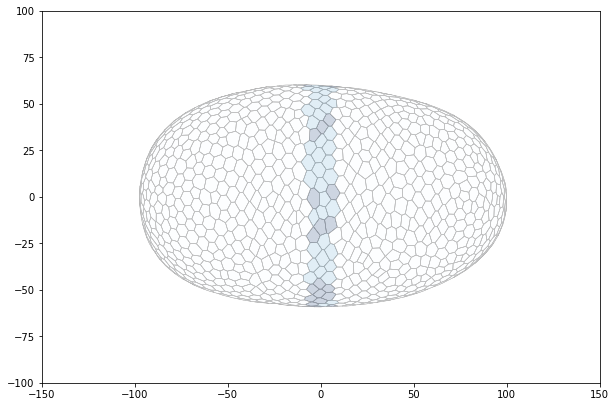

In [12]:
def draw_specs(sheet):
    specs = {
        'edge': {
            'visible': True,
            'color': sheet.edge_df['weight'],
            'colormap':'bwr',
            #'color_range':(-20,20)
        },
        'face': {
            'visible': True,
            'color':sheet.face_df.apoptosis+sheet.face_df.fold,
            'colormap': 'Blues',
            'alpha':0.2

        },
        'vert':{
            'visible':False,
            's':100,
            'alpha': 0.3,
            'zorder': 2,


        }

    }
    return specs


sheet_=sheet.extract_bounding_box(y_boundary=(0,150))
fig, ax = sheet_view(sheet_, ['z', 'x'], mode="2D", **draw_specs(sheet_))
ax.set_ylim(-100,100)
ax.set_xlim(-150,150)

fig.set_size_inches(10,10)

In [13]:
def run_sim(sim_save_dir, sheet2, constriction, radial_tension, iteration=0):
    
    # without copy, dataframe is on read only... 
    sheet = sheet2.copy()
    
    filename = '{}_constriction_{}_radialtension{}.hf5'.format(
        constriction,radial_tension, iteration)
    dirname = os.path.join(sim_save_dir, filename[:-4])
    
    print('starting {}'.format(dirname))
    try:
        os.mkdir(dirname)
    except IOError:
        pass
    
    # Add some information to the sheet and copy initial sheet
    sheet.face_df['id'] = sheet.face_df.index.values
    sheet.face_df['ablate'] = 0
    sheet.get_opposite()
    # Initiate history
    history = HistoryHdf5(sheet, 
                          extra_cols={"face": sheet.face_df.columns,
                                      "edge": list(sheet.edge_df.columns),
                                      "vert": list(sheet.vert_df.columns)},
                         hf5file=os.path.join(sim_save_dir, filename))
    
    # Initiate manager
    manager = EventManager('face')
    
    # Update kwargs...
    sheet.settings['apoptosis'].update(
                    {
                    'contract_rate':1.08,
                    #'radial_tension':radial_tension,
                    'radial_tension' : 50,
                    })
    
    #save settings
    pd.Series(sheet.settings).to_csv(os.path.join(dirname, 'settings.csv'))
   
    
    manager.append(reconnect, **sheet.settings['rosette_kwargs'])
    manager.append(apoptosis_patterning, **sheet.settings['apopto_pattern_kwargs'])
    
    sheet_ = sheet.extract_bounding_box(x_boundary=(-30,30), z_boundary=(-70,70))
    face_ = random.choice(sheet_.face_df.id.to_numpy())
    face = sheet.face_df[sheet.face_df.id == face_].index.to_numpy()[0]
    sheet.face_df.loc[face, 'ablate']=1
    t = 0.
    stop = 20.
    # Run simulation
    while t < stop:        
                
        # definir les jonctions à couper autour d'une cellule apoptotique

        face = sheet.face_df[sheet.face_df.id == face_].index.to_numpy()[0]
        #if sheet.face_df.loc[face, 'area'] < 15:    
        if t > 10:
            sheet.get_opposite()
            edge_opp = sheet.edge_df[sheet.edge_df.face==face].opposite.to_numpy()
            for v in sheet.edge_df[sheet.edge_df.face==face]['srce'].values:
                edge = np.concatenate((sheet.edge_df[(sheet.edge_df.srce==v) & (sheet.edge_df.face!=face)].index.values,
                       sheet.edge_df[(sheet.edge_df.trgt==v) & (sheet.edge_df.face!=face)].index.values))

                for e in edge :
                    if (sheet.edge_df.loc[e, 'trgt'] not in sheet.edge_df.loc[edge_opp].trgt.to_numpy() 
                        or sheet.edge_df.loc[e, 'srce'] not in sheet.edge_df.loc[edge_opp].srce.to_numpy()):
                        sheet.edge_df.loc[e, 'weight']=0

                    
        
        # Reset radial tension at each time step
        sheet.vert_df.radial_tension = 0.

        manager.execute(sheet)
        res = solver.find_energy_min(sheet, geom, model, options={"gtol": 1e-8})

        # add noise on vertex position to avoid local minimal.
        sheet.vert_df[
            ['x', 'y']] += np.random.normal(scale=1e-3, size=(sheet.Nv, 2))
        geom.update_all(sheet)
        
        
        # Save result in each time step.
        figname = os.path.join(
            dirname, 'invagination_{:04.0f}.png'.format(t))
        hdfname = figname[:-3] + 'hf5'        
        hdf5.save_datasets(hdfname, sheet)

        history.record(time_stamp=float(t))

        manager.update()
        t += 1.
    
    
    
    print('{} done'.format(dirname))
    print('~~~~~~~~~~~~~~~~~~~~~\n')

In [19]:
from joblib import Parallel, delayed
import multiprocessing
from datetime import datetime

global_start=datetime.now()
print ("start : " + str(global_start))
num_cores = multiprocessing.cpu_count()
#""" Initiale find minimal energy
# To be sure we are at the equilibrium before executing simulation 
# (it will be done only once if multiprocessing...)
#res = solver.find_energy_min(sheet, geom, model, options={"gtol": 1e-8})

radial_tension = [50.]

contractility_percent = [8]
contractility_rate = [1+c/100 for c in contractility_percent]
iteration = np.linspace(9,50, 42)

contractility_rate, radial_tension, it = np.meshgrid(contractility_rate, radial_tension, iteration)

results = Parallel(n_jobs=5)(delayed(run_sim)(
    sim_save_dir, sheet, c, rd, i) 
                 for  c, rd,i in zip(contractility_rate.ravel(), radial_tension.ravel(), it.ravel()))

global_end = datetime.now()
print ("end : " + str(global_end))
print ('Duree totale d execution : \n\t\t')
print (global_end-global_start)

start : 2020-01-13 12:29:26.487956
end : 2020-01-13 15:05:06.580360
Duree totale d execution : 
		
2:35:40.092404


In [15]:
dirname = '/home/admin-suz/Documents/Simulations/20200107-QSSolver-Homogenous_Ablation/1.08_constriction_50.0_radialtension0'

hfs = [f  for f in os.listdir(dirname) if f.endswith('hf5')]
hfs.sort()
from tyssue.draw.ipv_draw import edge_mesh, face_mesh

def get_meshes(dirname, hdf_file):
    dsets = hdf5.load_datasets(os.path.join(dirname, hdf_file),
                               data_names=['vert', 'edge', 'face'])
        
    sheet = Sheet('ellipse', dsets)
    faces = face_mesh(sheet, coords=['x', 'y', 'z'],
                      color=sheet.face_df['apoptosis'])
    
    #edges = edge_mesh(sheet, coords=['x', 'y', 'z'],
    #                  color=sheet.vert_df.y)
    edges = edge_mesh(sheet, coords=['x', 'y', 'z'],
                      color=sheet.edge_df.weight)

    return faces, edges

from ipywidgets import interact

def browse_sheets(dirname, hfs):
    n = len(hfs)
    ipv.clear()
    fig = ipv.gcf()
    meshes = get_meshes(dirname, hfs[0])
    fig.meshes = fig.meshes + list(meshes)
    
    def view_sheet(i):
        fig.animation = 0

        faces, edges = get_meshes(dirname, hfs[i])
        print()
        fig.meshes[0].x = faces.x
        fig.meshes[0].y = faces.y
        fig.meshes[0].z = faces.z
        fig.meshes[0].color = faces.color
        fig.meshes[0].triangles = faces.triangles

        fig.meshes[1].x = edges.x
        fig.meshes[1].y = edges.y
        fig.meshes[1].z = edges.z
        fig.meshes[1].color = edges.color
        fig.meshes[1].lines = edges.lines

        lim_inf = sheet.vert_df[sheet.coords].min().min()
        lim_sup = sheet.vert_df[sheet.coords].max().max()
        ipv.xyzlim(lim_inf, lim_sup)
    ipv.show()
    interact(view_sheet, i=(0, n-1))

FileNotFoundError: [Errno 2] No such file or directory: '/home/admin-suz/Documents/Simulations/20200107-QSSolver-Homogenous_Ablation/1.08_constriction_50.0_radialtension0'

In [ ]:
browse_sheets(dirname, hfs)